# Aave Safety Module - Slashing Percentage

This notebook generates the curves for modeling the insurance power and capital efficiency of the safety module with respect to the lashing percentage.

In [173]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.rcParams["font.family"] = "serif"
plt.rcParams.update({'font.size': 10})

In [134]:
def get_new_R(sm, p2):
    return sm.R * sm.p / p2 * (sm.r_0 + sm.r_other + p2 * sm.r_slash) / (sm.r_0 + sm.r_other + sm.p* sm.r_slash)

class SafetyModule():
    
    def __init__(self, R, p, r_0, r_other, r_slash) -> None:
        self.R = R
        self.p = p
        self.r_0 = r_0
        self.r_other = r_other
        self.r_slash = r_slash

    @property
    def apr(self):
        return self.r_0 + self.r_other + self.p*self.r_slash

    @property
    def insurance(self):
        return self.p*self.R/(self.r_0 + self.r_other + self.p*self.r_slash)
    
    @property
    def tvl(self):
        return self.R/self.apr
    
    def set_R(self, R):
        self.R = R
    
    def set_p(self, p):
        self.p = p
    
    def set_r_0(self, r_0):
        self.r_0 = r_0

    def set_r_other(self, r_other):
        self.r_other = r_other
    
    def set_r_slash(self, r_slash):
        self.r_slash = r_slash

In [137]:
p1 = 0.3

# As of June 29th 2023
R1 = 1_100 * 365 / 2
AAVE_apr = 0.0613
p_AAVE = 63 

r_0 = 0.03 # roughly USDC staking APR
r_other = 0 # Let's say it's negligible
r_slash = (AAVE_apr - r_0 - r_other)/0.3
print(f'Slashing Premium: {r_slash:.2%}')

Slashing Premium: 10.43%


AAVE pool at p = 0.3
Insurance Power: 61.90 (Mns USD)
TVL: 206.32 (Mns USD)
APR: 6.13%

AAVE pool at p = 1
Insurance Power: 94.15 (Mns USD)
TVL: 94.15 (Mns USD)
APR: 13.43%


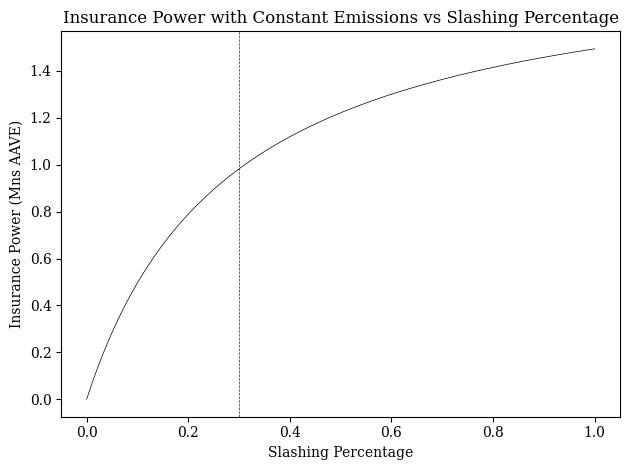

In [167]:
sm = SafetyModule(R1, 0.3, r_0, r_other, r_slash)
OLD_INSURANCE_POWER = sm.insurance
print(f'AAVE pool at p = 0.3\nInsurance Power: {sm.insurance*p_AAVE/1e6:.2f} (Mns USD)\nTVL: {sm.tvl*p_AAVE/1e6:.2f} (Mns USD)\nAPR: {sm.apr:.2%}')
print()
sm.set_p(1)
print(f'AAVE pool at p = 1\nInsurance Power: {sm.insurance*p_AAVE/1e6:.2f} (Mns USD)\nTVL: {sm.tvl*p_AAVE/1e6:.2f} (Mns USD)\nAPR: {sm.apr:.2%}')

x = np.linspace(0, 1, 100)
y = np.ones(len(x))
for i, xi in enumerate(x):
    sm.set_p(xi)
    y[i] = sm.insurance / 1e6

f, ax = plt.subplots()

ax.plot(x, y, linewidth=0.5, color='black')
ax.set_xlabel('Slashing Percentage')
ax.set_ylabel('Insurance Power (Mns AAVE)')
ax.set_title('Insurance Power with Constant Emissions vs Slashing Percentage')

ax.axvline(0.3, color='darkred', linestyle='--', linewidth=0.5)

f.tight_layout()
f.savefig('./figs/insurance_power.png', dpi=300)

In [139]:
p2 = 1
sm = SafetyModule(R1, 0.3, r_0, r_other, r_slash)

# Annual Savings
R2 = get_new_R(sm, p2)
AAVE_savings = R1 - R2
dollar_savings = AAVE_savings * p_AAVE

print(f'Annual Savings: {format(AAVE_savings, ",.2f")} AAVE')
print(f'Annual Savings: ${format(dollar_savings, ",.2f")}')

Annual Savings: 68,772.43 AAVE
Annual Savings: $4,332,663.13


In [169]:
# Get new APR
sm.set_R(R2)
sm.set_p(p2)
print(f'New APR: {sm.apr:.2%}')
print(f'New TVL: {sm.tvl*p_AAVE/1e6:.2f} (Mns USD)')
print(f'New Insurance Power: {sm.insurance*p_AAVE/1e6:.2f} (Mns USD)')
print(f'New Emissions Required: {sm.R:,.2f} AAVE')

New APR: 13.43%
New TVL: 61.90 (Mns USD)
New Insurance Power: 61.90 (Mns USD)
New Emissions Required: 131,977.57 AAVE


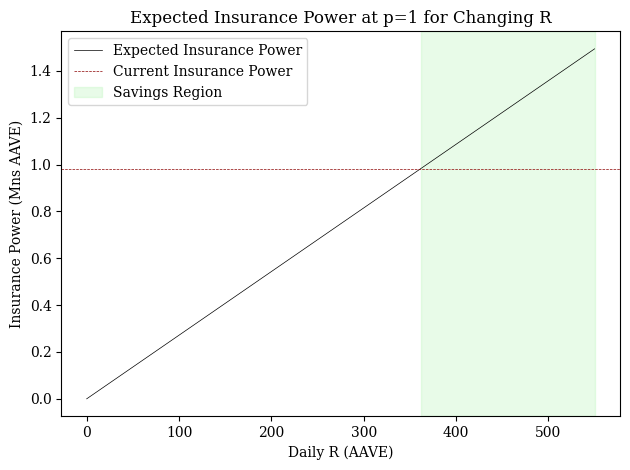

In [174]:
x = np.linspace(1, R1, 1000)
y = np.ones(len(x))
for i, xi in enumerate(x):
    sm.set_R(xi)
    y[i] = sm.insurance/1e6
x /= 365

f, ax = plt.subplots()

ax.plot(x, y, linewidth=0.5, color='black', label='Expected Insurance Power')
ax.axhline(OLD_INSURANCE_POWER/1e6, color='darkred', linestyle='--', linewidth=0.5, label="Current Insurance Power")
ax.axvspan(R1/365, R2/365, color='lightgreen', alpha=0.2, label='Savings Region')

ax.set_xlabel('Daily R (AAVE)')
ax.set_ylabel('Insurance Power (Mns AAVE)')
ax.set_title('Expected Insurance Power at p=1 for Changing R')
ax.legend()

f.tight_layout()
f.savefig('./figs/possible_savings.png', dpi=300)

In [ ]:
def heatmap():
    num_phis = 8
    num_sigmas = 10
    res = np.zeros((num_phis, num_sigmas))

    phis = [0] + [1/denom for denom in range(10, 3, -1)]
    phis = [round(phi, 3) for phi in phis]

    # print(np.apply_along_axis(lambda x: round(x, 4), 0, phis))
    sandwich_mults = np.linspace(.3, 2.0, num_sigmas)
    sandwich_mults = [round(mult, 3) for mult in sandwich_mults]

    for i, phi in enumerate(phis):
        for j, sigma in enumerate(sandwich_mults):
            res[i][j] = calcvaluepct(phi, sigma) # report the value in units of cents

    res = pd.DataFrame(
        res,
        index=phis,
        columns=sandwich_mults
    )

    sns.heatmap(
        res,
        cmap=sns.dark_palette("#D3D3D3", as_cmap=True),
#         annot=True
    )
    plt.title("Protocol Value per Dollar of Uninformed Orderflow on ETH-USDC 0.05\% Pool (¢)")
    plt.xlabel("Sandwich Multiple")
    plt.ylabel("Protocol Fee")
    plt.savefig("/Users/max/Desktop/sandwich-mult-heatmap.pdf")
    plt.show()
    
    cur_sandwich_multiple = .6969
    plt.scatter(
        phis,
        [calcvaluepct(phi, cur_sandwich_multiple) for phi in phis],
        color="black",
    )
    plt.title("Protocol Value per Dollar of Uninformed Orderflow on ETH-USDC 0.05\% Pool (¢)")
    plt.ylabel("Protocol Value")
    plt.xlabel("Protocol Fee")
    plt.savefig("/Users/max/Desktop/sandwich-mult-value-scatter.pdf")
    plt.show()
    
heatmap()